# Senior Wildfire Data Scientist

This take home exercise is designed for you to demonstrate technical competency with a short exercise.

We would like you to address the following prompts using the associated data file. We expect this exercise to take less than one hour depending on your familiarity with the APIs of Python packages like numpy, pandas and geopandas, shapely, and scikit-learn.

Please take extra care to fully read the prompts before beginning your work, as the final step is the most important.

## Submission instructions

1. Please submit a jupyter notebook with well-documented code, descriptive comments, and textual or visual outputs where necessary.
1. Please pay special attention to documenting your thought process. Tell us what you've learned, what questions arise, how you would build on this work, etc. 

## Prompts

### Description

A potential customer has provided Overstory with a data file containing ground-truth information from their network. They claim this data file has information on the location of their poles and lines, as well as counts of healthy and dead trees nearby those lines. They further claim that independent contractors have examined a subset of their network, and have rated lines as either low, medium, or high risk. We have no further information from the client as to how the healthy or dead tree counts were collected, how the risk ratings were generated, or generally how to interpret the data.

### Exploration

Your non-technical Overstory colleagues have a few questions about the data. Please feel free to use these questions as inspiration for exploring the data, and do not feel the need to dive deep on any particular question or uncover any profound patterns.
1. Can you say anything about the geographic distribution of the network? Please note there is no CRS with this data source, and the coordinates are completely fabricated.
1. Can we trust the counts of healthy and dead trees?
1. Are there any patterns to be found in the relationship between healthy and dead trees?
1. Are there any geographic patterns to be found in the distribution of healthy and dead trees?
1. What do the columns "*_near_line" mean?

### Modeling

Most importantly, it appears that only a subset of the risk ratings are available. Can we impress the customer by coming up with a model that predicts the risk ratings for the lines where risk rating is not available? Please show your work and communicate your confidence in this model. 

How would you recommend that your Overstory colleagues describe this work to the customer at their next meeting? Do you have any follow-up questions for the customer that would help you to extend your work?

# Setup Package Imports

In [119]:
import geopandas as gpd
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns

# Step 1. Exploratory Data Analysis (EDA)

# Read dataset

In [120]:
cwd = os.getcwd()
gdf = gpd.read_parquet(cwd+'/senior_wildfire_network_data.parquet')
print('columns\n',gdf.dtypes)
print('shape',gdf.shape)
print('head\n',gdf.head())

columns
 geometry                 geometry
tree_crowns               float64
dead_trees                float64
tree_crowns_near_line     float64
dead_trees_near_line      float64
risk                       object
dtype: object
shape (2517, 6)
head
                                                  geometry  tree_crowns  \
id                                                                       
2c9997  POLYGON ((3279033.158 228364.295, 3279032.478 ...          7.0   
b79db0  POLYGON ((3274243.292 229223.348, 3274241.510 ...         26.0   
e29aaf  POLYGON ((3277685.748 229360.692, 3277687.540 ...          2.0   
d9c9c5  POLYGON ((3280328.441 240473.400, 3280326.680 ...          7.0   
4f720b  POLYGON ((3261453.121 198662.801, 3261453.908 ...          0.0   

        dead_trees  tree_crowns_near_line  dead_trees_near_line    risk  
id                                                                       
2c9997        15.0                    0.0                   0.0    None  
b79db0    

let's look at the summary stats of those float64 columns - all the tree count data.

In [121]:
gdf.describe()

,tree_crowns,dead_trees,tree_crowns_near_line,dead_trees_near_line
count,2493.000000,2493.000000,2493.000000,2493.000000
mean,8.152427,4.974729,0.056959,0.176895
std,7.250397,7.166653,0.243628,0.571174
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000
50%,7.000000,3.000000,0.000000,0.000000
75%,13.000000,5.000000,0.000000,0.000000
max,33.000000,47.000000,2.000000,4.000000


We see that there are 2493 network segments with tree survey data. 
Counts of live and dead trees (`tree_crowns`, `dead_trees`) tend to be higher than live and dead trees near the utilitiy lines (`tree_crowns_near_line`, `dead_trees_near_line`).

Now we'll look at a frequency histogram of the risk column which is categorical.

Records with Risk scores: 651
As percent: 25.86%


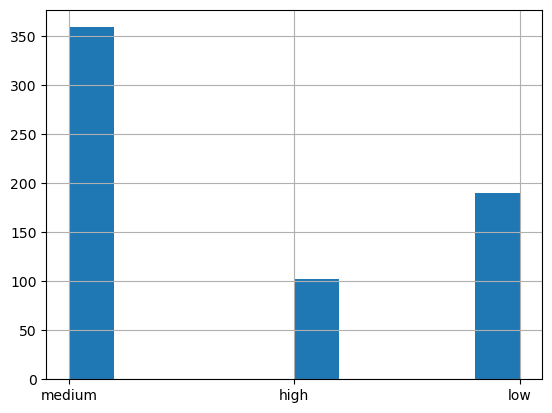

In [122]:
gdf.risk.hist()
print(f'Records with Risk scores: {(len(gdf) - gdf.risk.isna().sum())}')
print(f'As percent: {100*(len(gdf) - gdf.risk.isna().sum())/len(gdf):.2f}%')

It appears that the risk assessment was done on 651 records - 26% of the data. Looking at a histogram of counts per risk category, risk folllows a pretty normal distribution with the medium category containing more than 50% of the line segments assessed.

## Geographic Distribution of the network (Q1)

Without a CRS, there isn't much to say about the geographic location of the network. The dataset contains sequences of polygons that form a handful of contiguous stretches of utility network, likely just a sample of the total utility network within the minimum bouding extent of the dataset. 

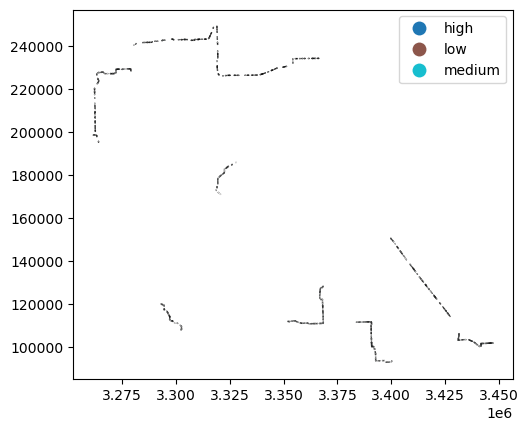

In [123]:
gdf.plot(edgecolor='black', column='risk', legend=True) # plot the geometries using one of the columns for symbolization
plt.show()

We assume that the polygons in this dataset are line buffers wherein trees were surveyed a certain distance from the network. Each line segment is of varying length making its survey area different. 

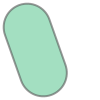

In [124]:
gdf.iloc[0].geometry

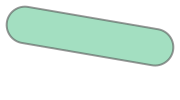

In [125]:
gdf.iloc[1].geometry

## Exploring the relationship between healthy and dead trees (Qs 2 & 3)

Even though there's no CRS we can still compute each polygon's area and see how these 'segment survey areas' relate to tree counts

/home/kyle/miniconda3/envs/overstory/lib/python3.13/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


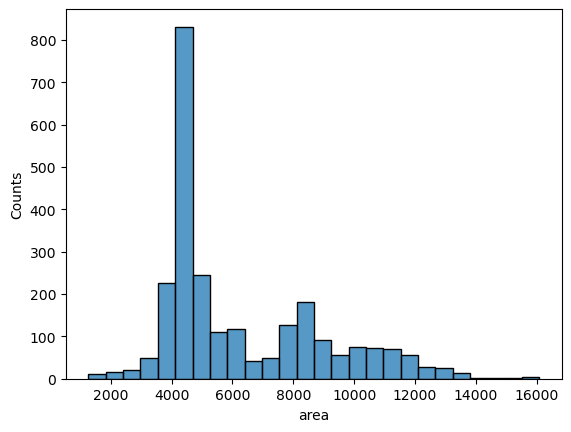

In [126]:
# make an area column and plot a histogram of the areas 
# assume values to represent sq meters
gdf['area'] = gdf.geometry.area
sns.histplot(gdf['area'], kde=False)
plt.ylabel('Counts')
plt.show()

Now we'll check out: 
* the relationship of the live to dead tree count in each segment area 
* segment area to live tree
* segment area to dead tree

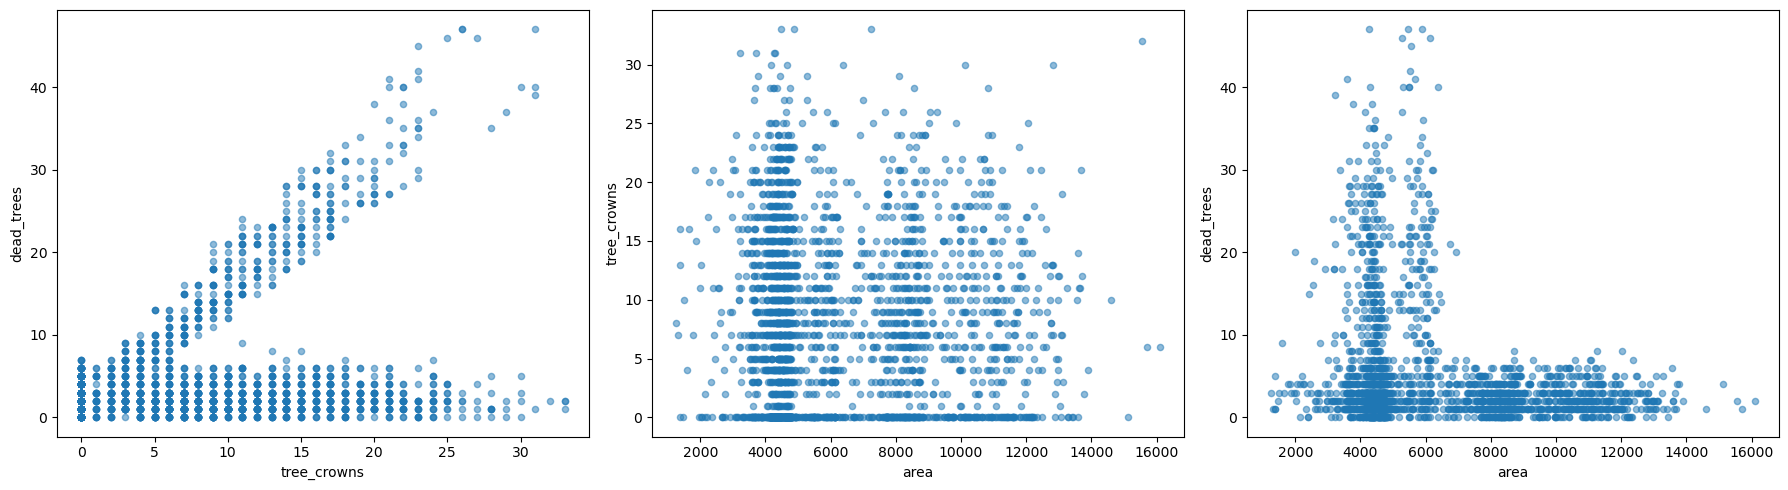

In [127]:
# Scatter plot tree crowns vs dead trees, 
# as well as the relationship between area of the surveyed segment area to live and dead tree counts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plot of tree_crowns vs dead_trees
gdf.plot.scatter(x='tree_crowns', y='dead_trees', alpha=0.5, ax=axes[0])

# Scatter plot of tree_crowns vs tree_crowns_near_line
gdf.plot.scatter(x='area', y='tree_crowns', alpha=0.5, ax=axes[1])

# Scatter plot of dead_trees vs dead_trees_near_line
gdf.plot.scatter(x='area', y='dead_trees', alpha=0.5, ax=axes[2])

plt.tight_layout()
plt.show()

The live to dead tree count scatterplot shows that there are sort of two patterns, 
1. segments where live and dead tree counts are very similar (1:1 diagonal)
2. segments where live trees far exceed dead trees.

In most real-world settings we expect to see these two patterns existing at the same time across a patchwork of human-environment influence. 

The pattern we don't see here (and don't expect to see) is where dead trees far exceed live trees, which we would really only ever see in a high-severity fire situation where everything including tree canopy is torched (in which case all aboveground utility assets would be torched too).

In terms of what we can expect from realistic count numbers, that's harder to judge - no species info or tree crown diameter, etc to gauge how many trees could realistically be counted in an area of X size. 

However, we do see in the far two right plots that the highest counts of live and dead tree counts occur in the 4000-8000 survey area range, which is the most frequently occurring size of segment. This is at least reassuring.

## Geographic patterns to be found in the distribution of healthy and dead trees (Q4)

its harder to get any insight from symbolizing the polygons (hard to see the colors on such skinny polygons).  
So we can plot them as points (polygon centroids) with a color gradient and transparency to make a nicer first visualization and pick apart the patterns. 

Let's make a few more columns that look at the relationship between live and dead trees so we can throw them on a plot and try to make sense of the relationship

In [128]:
import numpy as np
# Compute diff, sum, product and ratio of 'tree_crowns' and 'dead_trees' columns
gdf['live_dead_product'] = gdf['tree_crowns'] * gdf['dead_trees']
gdf['live_dead_diff'] = gdf['tree_crowns'] - gdf['dead_trees']
gdf['live_dead_sum'] = gdf['tree_crowns'] + gdf['dead_trees']

# divide by 0 edge case needs to be handled for ratio calculation
gdf['live_dead_ratio'] = gdf['tree_crowns'] / gdf['dead_trees']
gdf['live_dead_ratio'] = gdf['live_dead_ratio'].replace([np.inf, -np.inf], np.nan)
gdf['live_dead_ratio'] = gdf['live_dead_ratio'].fillna(0)

print(gdf[['tree_crowns','dead_trees','live_dead_diff','live_dead_sum','live_dead_ratio','live_dead_product']].head(5))

        tree_crowns  dead_trees  live_dead_diff  live_dead_sum  \
id                                                               
2c9997          7.0        15.0            -8.0           22.0   
b79db0         26.0        47.0           -21.0           73.0   
e29aaf          2.0         5.0            -3.0            7.0   
d9c9c5          7.0         3.0             4.0           10.0   
4f720b          0.0         1.0            -1.0            1.0   

        live_dead_ratio  live_dead_product  
id                                          
2c9997         0.466667              105.0  
b79db0         0.553191             1222.0  
e29aaf         0.400000               10.0  
d9c9c5         2.333333               21.0  
4f720b         0.000000                0.0  


Looking at the original 4 tree columns plus risk as reference

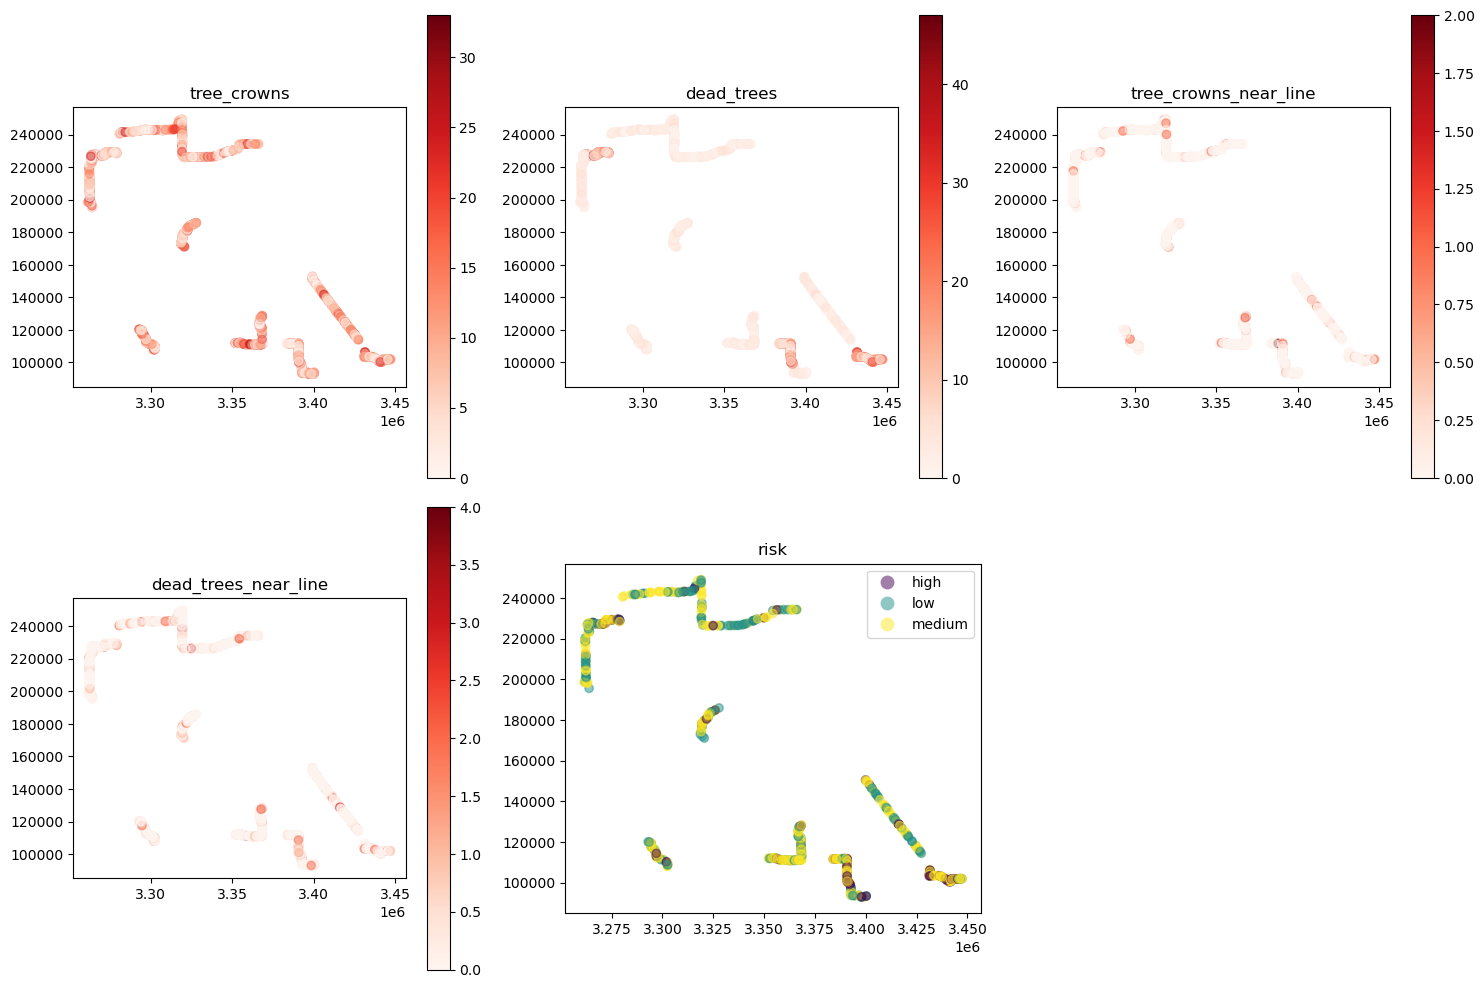

In [161]:
# plot a 2x3 subplot axis where each plot draws the dataset's centroids but symbolizes them by each of the columns
plt.colormaps()
gdf_plotter = gdf.copy() # make a copy of the dataframe so we can convert the geometry to centroids
gdf_plotter['geometry'] = gdf_plotter.centroid # convert the geometry to centroids

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# columns = ['live_dead_sum','live_dead_diff','live_dead_product','live_dead_ratio','risk']
columns = ['tree_crowns', 'dead_trees', 'tree_crowns_near_line','dead_trees_near_line','risk']
for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    cmap = 'viridis' if col == 'risk' else 'Reds'
    gdf_plotter.plot(column=col, 
             legend=True, 
             ax=ax, 
             alpha=0.5, 
             cmap=cmap)
    ax.set_title(col)

# Hide the last empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


* We can see that there are some high concentrations of dead trees and dead trees near line in the bottom right corner of the network. 
* tree crowns and tree crowns near line appear to be in highest concentrations in the top 'Z' shaped network top center. 
* The areas hwere we see high risk light up appear to coincide more with dead trees and live or dead trees near line than generally where there's high 'tree_crowns'.

Lets plot those new columns that look at live to dead tree crown relationships per segment

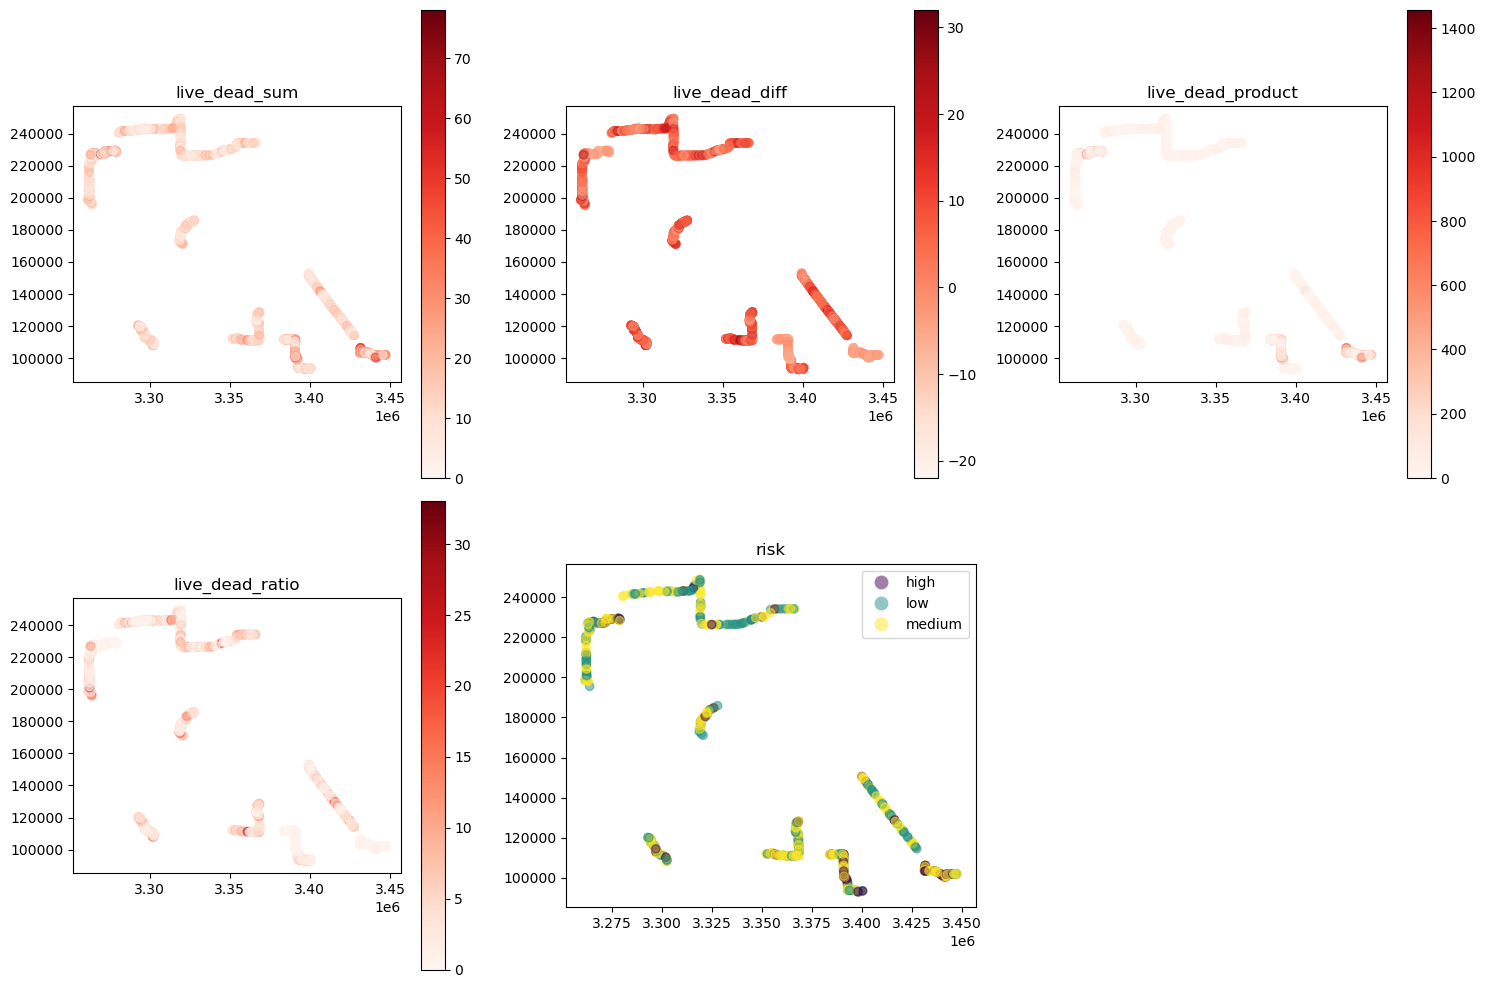

In [162]:
# plot a 2x3 subplot axis where each plot draws the dataset's centroids but symbolizes them by each of the columns
plt.colormaps()
gdf_plotter = gdf.copy() # make a copy of the dataframe so we can convert the geometry to centroids
gdf_plotter['geometry'] = gdf_plotter.centroid # convert the geometry to centroids

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
columns = ['live_dead_sum','live_dead_diff','live_dead_product','live_dead_ratio','risk']
# columns = ['tree_crowns', 'dead_trees', 'tree_crowns_near_line','dead_trees_near_line','risk']
for i, col in enumerate(columns):
    ax = axes[i // 3, i % 3]
    cmap = 'viridis' if col == 'risk' else 'Reds'
    gdf_plotter.plot(column=col, 
             legend=True, 
             ax=ax, 
             alpha=0.5, 
             cmap=cmap)
    ax.set_title(col)

# Hide the last empty subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

although the additive (sum and product) and differential (diff and ratio) tell the same story with slightly different color gradients, we can say a few things from these plots taken together:

* the bottom right stretch of network appears to contain one of the highest concentrations of trees both live and dead, though those network segements in that stretch appear to have a more equal ratio of live to dead than in other areas.
* the fourth stretch of network from the bottom right, shaped like a backwards 'L', contains one or two line segment areas with thie highest ratio of live to dead tree counts, though it doesn't contain the most trees in the dataset.  

## EDA Key Takeaways 


So can we trust the live and dead tree counts? Most likely, the data exhibit patterns that you would naturally expect to find along forested right-of-ways. But we would obviously want to hear more about the actual data collection process involved to feel better about using the data.

Its also apparent that there's a notable difference between segments with high live tree crowns and those with more trees near line or more dead trees in general, as it pertains to risk. This instills more confidence that the 'risk' assessments performed by the contractors are based in reality and the data is not fabricated.

### What do the columns '*near_line' mean (Q5)? 

Within the specific buffer survey area of a line segment it seems like the data collection process was to count all live and dead trees, but to also count live and dead trees falling within that 'near_line' threshold distance. 

This must be a certain linear buffer distance to the line but also it must be looking at distance on Z axis (height) as well. This measurement could be done in the field with some manual measurements or with LiDAR scanners  - airborne via manned or unmanned aircraft or even terrestrial LiDAR.

# Step 2. Modeling

### Pattern Exploration

Before we make an ML model it helps to see if we can't pick apart the label classes ourselves just looking at some of the input features we have available. This can help with intuition about model performance and inform any more feature engineering that could be useful later.

So lets look at the distribution of the tree column values per risk label to see if the labels are separable just by some variable distributions.

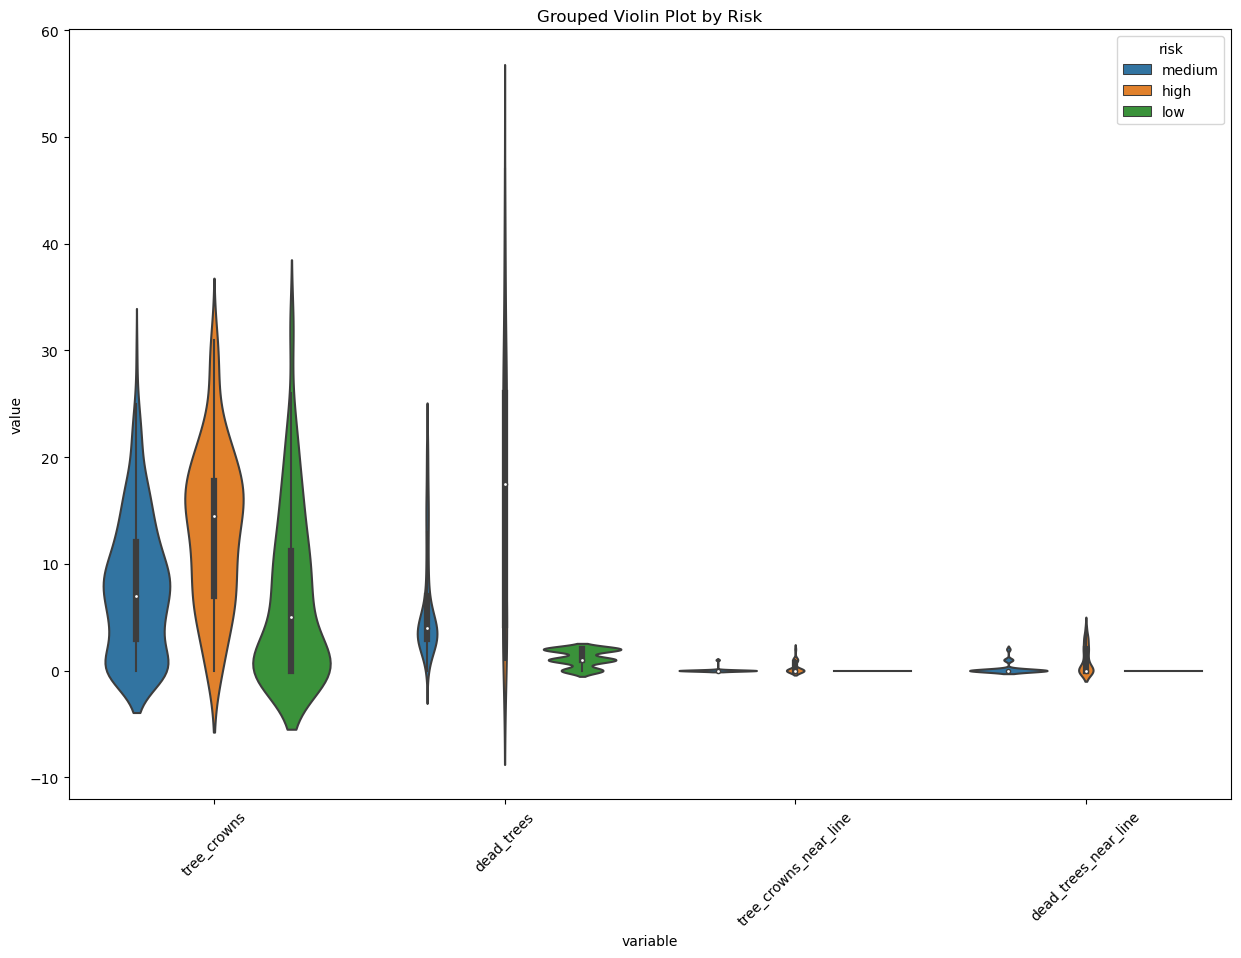

In [163]:
# Melt the dataframe to long format for seaborn
melted_gdf = gdf.melt(id_vars='risk', 
                      value_vars=['tree_crowns', 'dead_trees', 'tree_crowns_near_line', 'dead_trees_near_line'], 
                        var_name='variable', 
                        value_name='value')

# Create the violin plot
plt.figure(figsize=(15, 10))
sns.violinplot(x='variable', 
               y='value', 
               hue='risk', 
               data=melted_gdf, 
               )
plt.xticks(rotation=45)
plt.title('Grouped Violin Plot by Risk')
plt.show()

Where the risk categories start to differ is with the last three columns: dead trees, live and dead trees near the line. Especially interesting is that for all three of those columns the upper 50% of their value distribution is highest across the board for high risk labels. We also like to see that the opposite is true for low risk labels, where the value distribution is centering close to 0 on `*_near_line` columns and around 5 on dead_trees. 

A simple ML model should be able to separate the samples based on these and a few other ancillary variables.

### Train the Model

In [147]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Prepare the data
# Drop rows with missing risk values and select relevant columns
gdf_risk = gdf.dropna(subset=['risk'])
features = gdf_risk[['tree_crowns', 
                     'dead_trees', 
                     'tree_crowns_near_line', 
                     'dead_trees_near_line', 
                     'live_dead_product', 
                     'live_dead_diff', 
                     'live_dead_sum', 
                     'live_dead_ratio']]
labels = gdf_risk['risk']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# look at train and test splits as well as class balance
# print(f"Training set: {len(X_train)} samples")
# print(f"Testing set: {len(X_test)} samples")
print(f"Frequency distribution of risk labels for y_train (n={len(y_train)}):")
print(y_train.value_counts())
print(f"\nFrequency distribution of risk labels for y_test (n={len(y_test)}):")
print(y_test.value_counts())

# Initialize the model
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

Frequency distribution of risk labels for y_train (n=455):
risk
medium    253
low       131
high       71
Name: count, dtype: int64

Frequency distribution of risk labels for y_test (n=196):
risk
medium    106
low        59
high       31
Name: count, dtype: int64


RandomForestClassifier(random_state=42)

###  Model Evaluation

Let's first look at variable importance real quick to get a better understanding of the input feature space. 

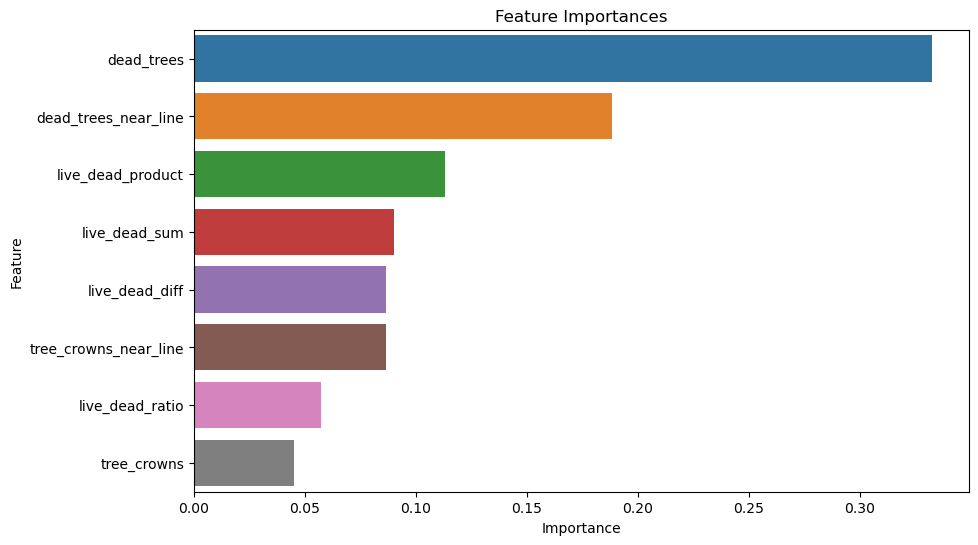

In [148]:
# Get feature importances
importances = model.feature_importances_
feature_names = features.columns

# Create a DataFrame for visualization
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.show()

dead trees and dead trees near line are most important. Makes sense, dead trees are like match sticks waiting for a spark. If we had a lot more features we could use variable importance insights to remove least important features as inputs to the model, but for simplicity sake we'll keep all the features.

Now lets make predictions on the test set and calculate our various performance metrics

In [149]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 25   0   6]
 [  0  59   0]
 [  4   0 102]]

Classification Report:
              precision    recall  f1-score   support

        high       0.86      0.81      0.83        31
         low       1.00      1.00      1.00        59
      medium       0.94      0.96      0.95       106

    accuracy                           0.95       196
   macro avg       0.94      0.92      0.93       196
weighted avg       0.95      0.95      0.95       196



## Modeling Takeaways

A simple Random Forest with a 70/30 train/test split on a simple random sample does quite well. We achieve weighted F1-score and accuracy of 0.95. We can be especially confident about any low and medium predictions as their f1 scores are 1 and 0.95 respectively. However, the model has a harder time with the 'high' label, with F1 score of 0.83. Looking at the confusion matrix, the medium and high labels are being mixed up a bit (medium and low are out of order in risk column due to alphabetic sorting FYI). 

Of course the 'high' risk label is likely the most important category to a customer in this use case, but an F-1 of 0.83 is still within the range of something we could put into production depending on downstream requirements. I would still say this model or product idea is worth showing to the customer, but if we were to build a product around this we would obivously need way more data to validate and improve it across different geographies. 

If we had more data, some low effort improvements we could look at include a more nuanced sampling strategy like oversampling high risk labels. With less data at our disposal we could still try to synthetically agument the sample size with bootstrapping. Further down the road, we could look into more feature engineering work.

### Model Inference

We can now make inferences with this model on the line segments with no risk score and send this back to client.

In [134]:
gdf_risk_infer = gdf[gdf['risk'].isna()]
gdf_risk_infer.head(5)

,geometry,tree_crowns,dead_trees,tree_crowns_near_line,dead_trees_near_line,risk,area,live_dead_product,live_dead_diff,live_dead_sum,live_dead_ratio
id,,,,,,,,,,,
2c9997,"POLYGON ((3279033.158 228364.295, 3279032.478 ...",7.0,15.0,0.0,0.0,None,2426.796950,105.0,-8.0,22.0,0.466667
b79db0,"POLYGON ((3274243.292 229223.348, 3274241.510 ...",26.0,47.0,0.0,0.0,None,5884.856940,1222.0,-21.0,73.0,0.553191
e29aaf,"POLYGON ((3277685.748 229360.692, 3277687.540 ...",2.0,5.0,0.0,2.0,None,5452.741561,10.0,-3.0,7.0,0.400000
4f720b,"POLYGON ((3261453.121 198662.801, 3261453.908 ...",0.0,1.0,0.0,0.0,None,5405.643373,0.0,-1.0,1.0,0.000000
56bfa3,"POLYGON ((3400084.238 150310.249, 3400083.018 ...",21.0,4.0,0.0,2.0,None,8125.262804,84.0,17.0,25.0,5.250000


In [135]:
gdf_risk_infer.loc[:,'risk'] = model.predict(gdf_risk_infer[['tree_crowns', 
                                                 'dead_trees', 
                                                 'tree_crowns_near_line', 
                                                 'dead_trees_near_line', 
                                                 'live_dead_product', 
                                                 'live_dead_diff', 
                                                 'live_dead_sum', 
                                                 'live_dead_ratio']])
gdf_risk_infer.head(5)

,geometry,tree_crowns,dead_trees,tree_crowns_near_line,dead_trees_near_line,risk,area,live_dead_product,live_dead_diff,live_dead_sum,live_dead_ratio
id,,,,,,,,,,,
2c9997,"POLYGON ((3279033.158 228364.295, 3279032.478 ...",7.0,15.0,0.0,0.0,medium,2426.796950,105.0,-8.0,22.0,0.466667
b79db0,"POLYGON ((3274243.292 229223.348, 3274241.510 ...",26.0,47.0,0.0,0.0,high,5884.856940,1222.0,-21.0,73.0,0.553191
e29aaf,"POLYGON ((3277685.748 229360.692, 3277687.540 ...",2.0,5.0,0.0,2.0,high,5452.741561,10.0,-3.0,7.0,0.400000
4f720b,"POLYGON ((3261453.121 198662.801, 3261453.908 ...",0.0,1.0,0.0,0.0,low,5405.643373,0.0,-1.0,1.0,0.000000
56bfa3,"POLYGON ((3400084.238 150310.249, 3400083.018 ...",21.0,4.0,0.0,2.0,high,8125.262804,84.0,17.0,25.0,5.250000


And we can look at the distribution of our inferences vs distirbution of original ground truth risk just to see if the patterns change for the rest of the unassessed, modeled segments.

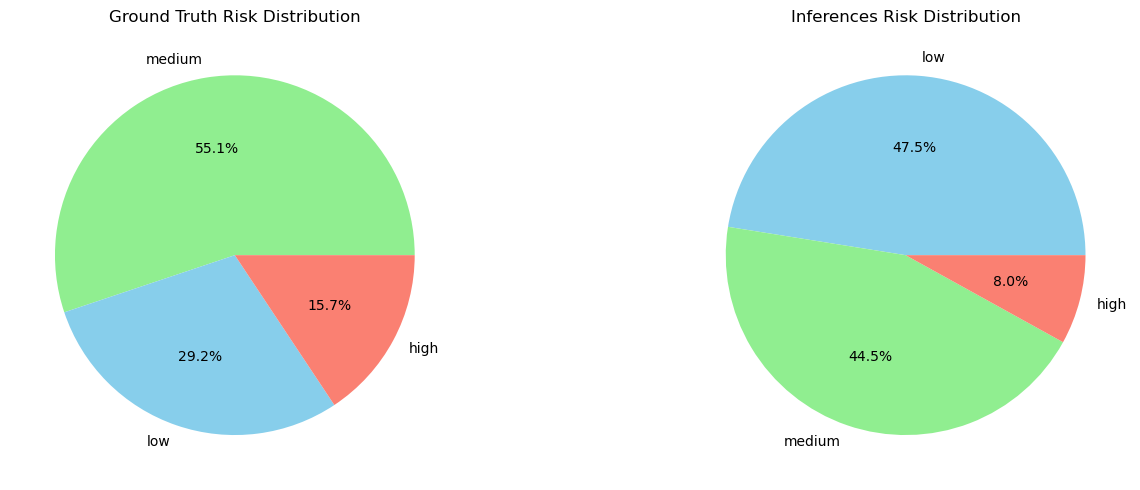

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Pie chart for original gdf
gdf['risk'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%', colors=['lightgreen','skyblue', 'salmon'])
axes[0].set_title('Ground Truth Risk Distribution')
axes[0].set_ylabel('')

# Pie chart for gdf_no_risk
gdf_risk_infer['risk'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon'])
axes[1].set_title('Inferences Risk Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


Looks like the model is predicting higher share of low risk and lower share of medium and high risk than in the ground truth samples. This is something the client might be happy to see, especially if we express our confidence in our model. Every 'low' risk line segment that we can confidently model is money saved by the client by not having to pay a contractor for a field inspection.

### Delivery

Finally, lets save the inferences to a new .parquet file and deliver to the client in addition to some of our questions about the data collection process.

In [137]:
gdf_risk_infer.drop(columns=['live_dead_product', 
                             'live_dead_diff', 
                             'live_dead_sum', 
                             'live_dead_ratio',
                             'area'], inplace=True)
gdf_risk_infer.to_parquet(cwd+'/senior_wildfire_network_data_inferred.parquet')

/tmp/ipykernel_834182/3903821408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf_risk_infer.drop(columns=['live_dead_product',


# Customer Response

I would have my colleagues tell them that we explored the data ourselves and found it to be robust. I would mention that we have a potential automation solution that we could provide for their risk assessment program and show them the inference results, making sure to share the model performance takeaways in plain language. Then I'd pitch that this model could exponentially incrase their line risk assessment coverage but that we would need more data from manual contractor surveys to ensure it is as accurate or more accurate than the manual surveys going forward. 

My questions are:
* How was the measurement done to count live and dead trees near line? 
    * might help with understanding model sensitivity down the road if we get better understanding of the method and precision of those measurements
* What is the decision process like for selecting which utility segments to survey?
    * best to understand, and if possible, reduce systematic sampling bias for the model
* Is a risk determination influenced by other factors not including the trees, like depending on primary overhead voltage?
    *  From my previous experience surveying utility poles I know there are different levels of safety concern depending what's on a pole or span of line, so if the electrification specs need to be known for a span to make a risk determination, that would be good for us to incorporate into the model.